In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

path = './input/'

data = pd.read_csv(path + 'train.csv')
data.shape

(891, 12)

In [208]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [209]:
col_na = []
nb_na = np.zeros(data.shape[1])
for i in range(data.shape[1]):
    col_na.append(data.columns[i])
    nb_na[i] = data.iloc[:,i].isna().sum()
df_na = pd.DataFrame(col_na, nb_na)
df_na

#We need to find a way to fill Age and Cabin

,0
0.0,PassengerId
0.0,Survived
0.0,Pclass
0.0,Name
0.0,Sex
177.0,Age
0.0,SibSp
0.0,Parch
0.0,Ticket
0.0,Fare


In [210]:
df_sex = data[['PassengerId','Survived','Sex']].groupby(['Sex', 'Survived']).count()
df_sex

PassengerId
Sex    Survived             
female 0                  81
       1                 233
male   0                 468
       1                 109

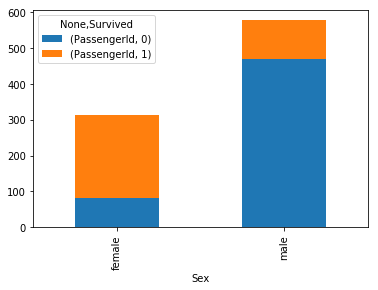

In [211]:
df_sex.unstack().plot(kind='bar', stacked=True)
#Most females survived while most men died. Corrolation?

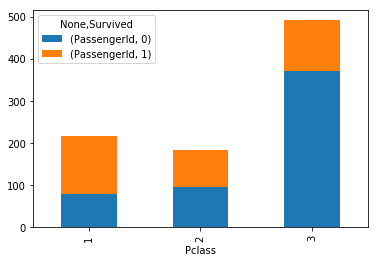

In [212]:
df_class = data[['PassengerId','Survived','Pclass']].groupby(['Pclass', 'Survived']).count()
df_class.unstack().plot(kind='bar', stacked=True)

#People in higher classes survived more. Corrolation?

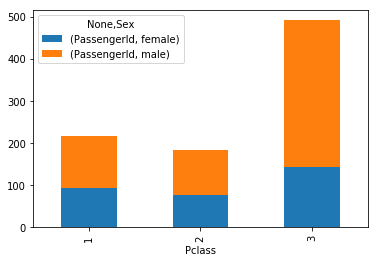

In [213]:
df_sex_class = data[['PassengerId','Sex','Pclass']].groupby(['Pclass', 'Sex']).count()
df_sex_class.unstack().plot(kind='bar', stacked=True)

#More females in higher classes (1 and 2). What can we conclude? 
#Did females survive more because they were wealthy?
#Did wealthier people survive more because they had a high ratio of females?

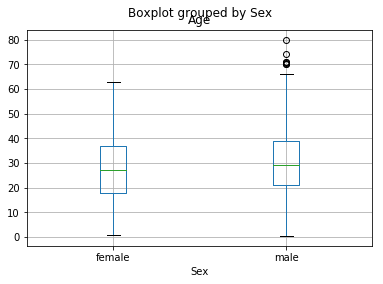

In [214]:
### To fill missing age, we can look for a relationship with other variables

data.boxplot('Age', by='Sex')

#Age is distributed differently for males and females

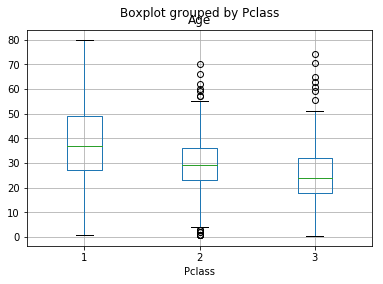

In [215]:
data.boxplot('Age', by='Pclass')

#Age is distributed even more differently depending on class

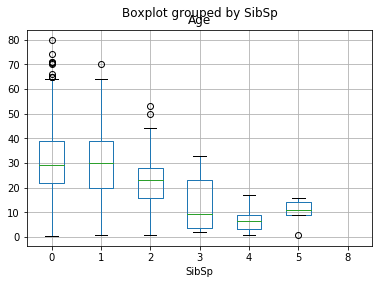

In [216]:
data.boxplot('Age', by='SibSp')

#Someone with a SibSp higher than 2 is travelling with siblings,
#it's more likely to be someone young travelling with their family

In [226]:
data = data.replace('male', 0)
data = data.replace('female', 1)
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",0,32.0,0,0,370376,7.75,NaN,Q


In [228]:
#We can try to fill the missing age values thanks to class and gender, using KNN

reg = KNeighborsRegressor(n_neighbors=5)
data_age = (data.loc[data['Age'].isna() == False]).iloc[:,[2,4,5,6]]
X_age = data_age[['Pclass', 'Sex', 'SibSp']]
y_age = data_age['Age']
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X_age, y_age, test_size=0.33)
reg.fit(X_age_train, y_age_train)
pred_age = reg.predict((data.loc[data['Age'].isna() == True]).iloc[:,[2,4,6]])
pred_age

array([26.3, 28.4, 28.2, 26.3, 28.2, 26.3, 39.4, 28.2, 26.3, 26.3, 26.3,
       16. , 28.2, 28.4, 30.2, 30.2, 16. , 26.3, 26.3, 28.2, 26.3, 26.3,
       26.3, 26.3, 29.2, 26.3, 26.3, 29.2, 28.2, 26.3, 26.3,  9.4, 35.4,
       30.2, 14.6,  8.4, 28.4, 30.2, 29.2, 26.3, 28.2,  9.4, 16. , 26.3,
       13.4, 28.2, 29.2, 29.2, 26.3, 35.4, 26.3, 28.2, 30.2, 28.2, 28.4,
       30.2, 30.2, 30.2, 28.2, 28.4, 33.6, 26.3, 35.4,  9.4, 19. , 39.4,
       26.3, 29.2, 30.2, 26.3, 28.2, 28.2, 16. , 28.2, 28.2, 39.4, 26.3,
       26.3, 13.4, 26.3, 26.3, 28.4, 28.2, 26.3, 26.3, 26.3, 29.2, 26.3,
       16. , 26.3, 39.4, 26.3, 26.3, 28.4, 26.3, 26.3, 30.2, 28.4, 13.4,
       16. , 26.3, 26.3, 28.2, 30.2, 26.3, 26.3, 26.3, 26.3, 30.2, 26.3,
       28.2, 26.3, 28.4, 26.3, 30.2, 26.3, 26.3, 28.2, 26.3, 28.2, 29.2,
       26.3, 26.3, 28.2, 33.6, 26.3, 26.3, 30.2, 26.3, 29.2, 26.3, 26.3,
       30.2, 16. , 26.3, 26.3, 26.3, 28.2, 26.3, 26.3, 39.4, 28.4, 28.2,
       26.3, 28.2, 16. , 30.2, 26.3, 28.2, 28.4, 26

In [229]:
reg.score(X_age_test, y_age_test)

0.09919307258125809

In [219]:
i = 0
for j in range(891):
    if(np.isnan(data.loc[j, 'Age'])):
        data.loc[j, 'Age'] = pred_age[i]
        i += 1
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,25.2,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",0,32.0,0,0,370376,7.75,NaN,Q


In [ ]:
### Let's test the "sink or swmin together" therory by using SibSp and Parch



In [220]:
data[['PassengerId', 'Pclass']].where(data['Cabin'].isna()).groupby(['Pclass']).count()

,PassengerId
Pclass,
1.0,40
2.0,168
3.0,479


In [221]:
data[['PassengerId', 'Pclass']].groupby(['Pclass']).count()

,PassengerId
Pclass,
1,216
2,184
3,491
